# Context
A patient with a brain tumor requires therapeutic treatment for a period of time. He must undergo a MRI examination every 4 months to follow the evolution of the tumor. One important information for evaluating treatment is the change in tumor size between exams. <br>
Our purpose is to calculate the percentage change in tumor size between exams using FCM as a segmentation method.

# Data Exploration
Before implementing the FCM algorithm, let's first investigate our data and present some insights by plotting the images and their corresponding histograms :

In [1]:
import numpy as np
from scipy.ndimage import label, generate_binary_structure
from scipy import ndimage
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import random
%matplotlib inline 

Image 1 : 


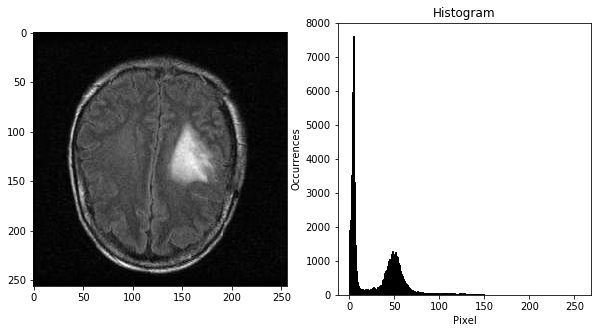

Image 2 : 


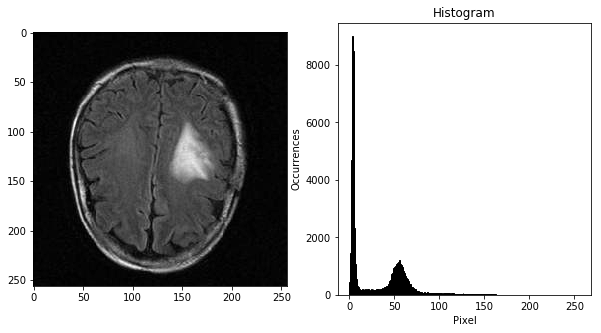

In [2]:
# read images and convert them to matrices
def image_to_array(image) :
    X = Image.open(image).convert("L")
    img = np.asarray(X)
    return img

# plot images and their histograms
def plot(img):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[1].hist(img.ravel(), bins=256, range=(0.0, 256), fc='k', ec='k')
    ax[1].set(title = "Histogram")
    ax[1].set(xlabel = "Pixel")
    ax[1].set(ylabel = "Occurrences")
    plt.show()
    
# List of images 
IMAGES = [ "../Data/IRMcoupe17-t1.jpg", "../Data/IRMcoupe17-t2.jpg"]

for i, image in enumerate(IMAGES):
    print("Image " + str(i+1) + " : ")
    img = image_to_array(image)
    plot(img)

As we can see, there are three main regions : the brain, the background and the tumor. By observing the histogram, one can segment *manually* the image by specifying two thresholds. For instance, let's choose $T_1 = 25$ and $T_2 = 80$. By doing so, we created three regions : the pixels less than $T_1$, the pixels laying between $T_1$ and $T_2$ and the ones greater than $T_2$.<br>
Let's display the three regions according to the previous thresholds :

Image 1 : 


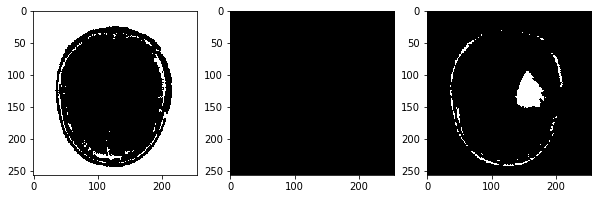

Image 2 : 


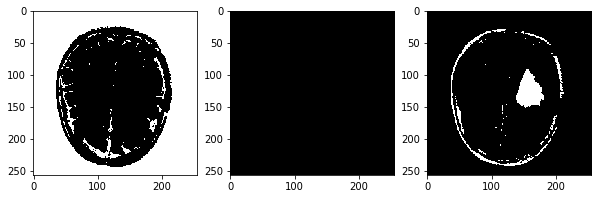

In [3]:
# Choosing manually the thresholds
T1, T2 = 25, 80

# Thresholding the images
for i, image in enumerate(IMAGES):
    print("Image " + str(i+1) + " : ")
    img = image_to_array(image)
    img1 = img < T1
    img2 = img > T1
    img2 = img2 < T2
    img3 = img > T2
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(img1, cmap='gray',  interpolation='nearest')
    ax[1].imshow(img2, cmap='gray',  interpolation='nearest')
    ax[2].imshow(img3, cmap='gray',  interpolation='nearest')
    plt.show()

Now we will perform this segmentation using machine learning and by applying the FCM algorithm.

# Image Segmentation using Fuzzy C-Means (FCM) Algorithm
Before implementing the *fuzzy c-means algorithm*, let's first describe its steps compared to our problem : <br>
1. Inputs : image ; K number of clusters
2. Assign randomly to each pixel its degree of cluster affiliation
3. Repeat until convergence ( the objective function to minimize is $J = \sum_{i=1}^{K} \sum_{k=1}^{n} \mu_{ki}^m \| y_k - v_i\|^2 $ where $y_k$ is the value of the pixel $k$, $v_i$ is the centroid of the cluster $i$ and $\mu_{ki}$ is the degree of affiliation of the pixel $k$ to the cluster $i$ ) : <br>
<ul>
<li> Compute the centroids $v_i$ while taking into account the degrees of cluster affiliation : <br>
$$ v_i = \frac{\sum_{k=1}^{n}\mu_{ki}^m y_k }{\sum_{k=1}^{n}\mu_{ki}^m} $$
<li> Update for each pixel its degree of cluster affiliation :
$$ \mu_{ki} = \frac{1}{\sum_{j=1}^{K} (\frac{d_{ki}}{d_{kj}})^r} $$
$$ \text{With :  } r = \frac{2}{m - 1} \text{  and  } d_{ki} = \| y_k - v_i\| $$. 
</ul>
<br>
The lines of code below will implement from scratch the algorithm and apply it to the first image. The final results will show the image after segmentation at convergence, the evolution of the centroids and the objective function. The intermediate results will show the evolution of the segmentation process at each five iterations.

Objective function value at iteration 1 : 22861606.720513012


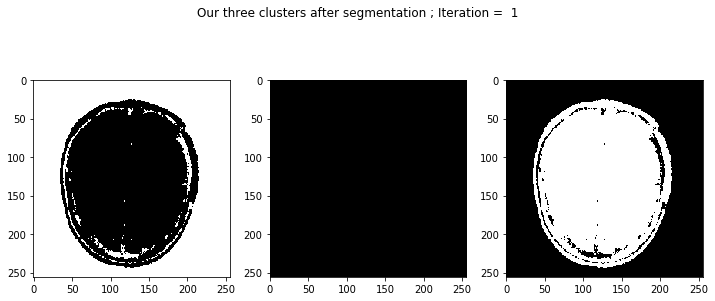

Objective function value at iteration 6 : 5841002.922829465


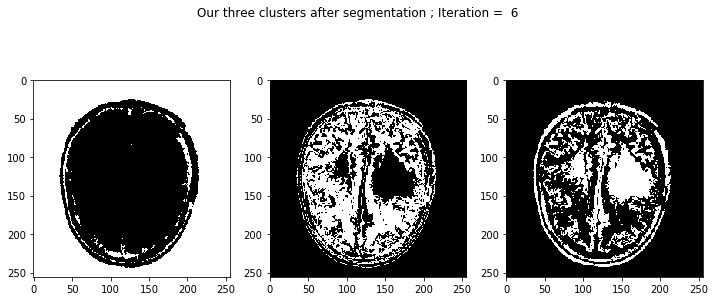

Objective function value at iteration 11 : 4109668.5070102713


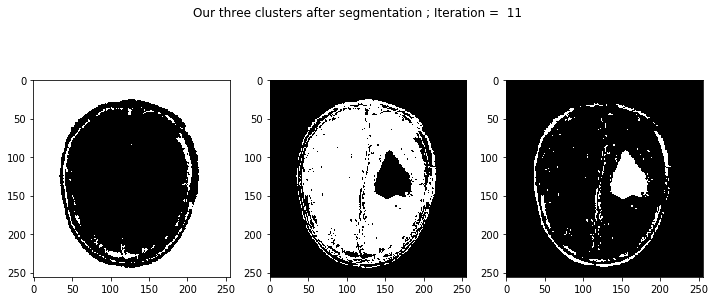

Objective function value at iteration 16 : 3302560.8474106085


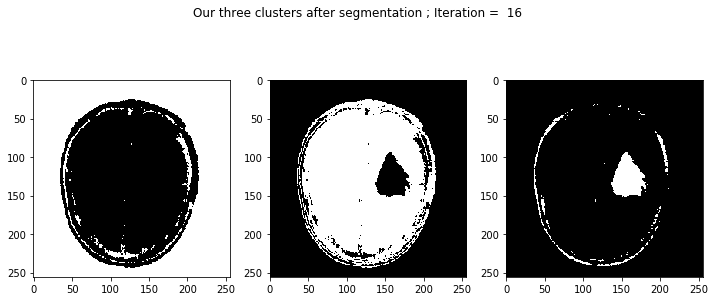

Objective function value at iteration 21 : 3284132.4619366345


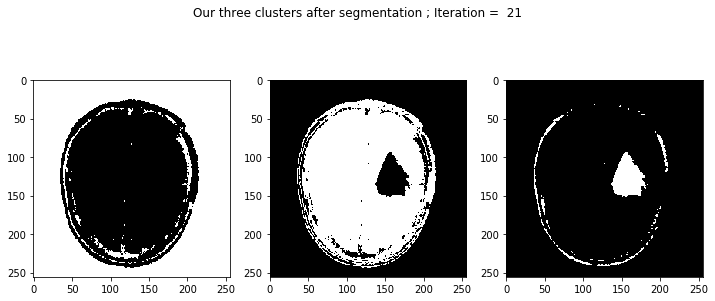

Objective function value at iteration 26 : 3284071.228956533


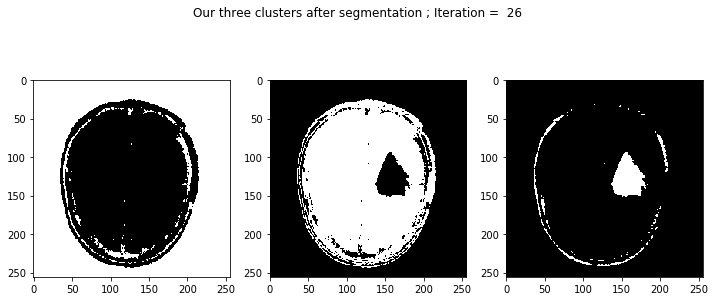

Objective function value at iteration 31 : 3284071.05891669


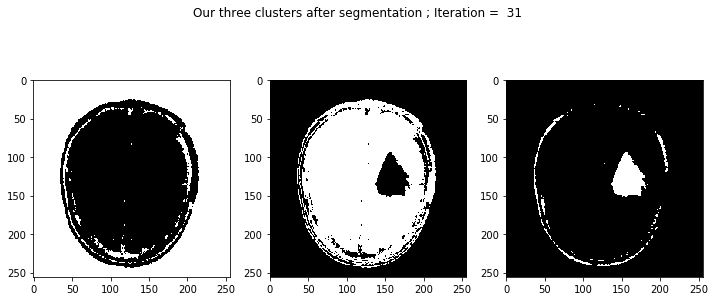

Convergence reached at iteration 32


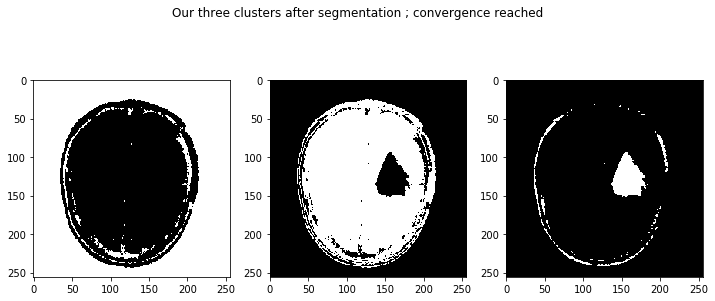

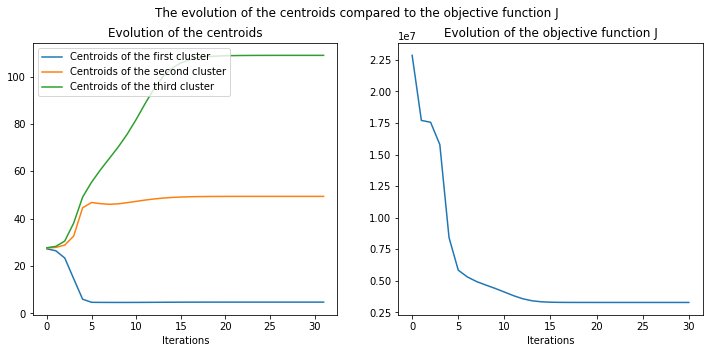

In [4]:
# our image
img1 = image_to_array(IMAGES[0])

# dimension of the image
n, d = img1.shape

# number of clusters
K = 3

# fuzzifier
m = 2

# matrix of pixels and degrees of cluster affiliation
input_matrix = np.zeros((n*d, K + 1))

# function that computes randomly the degrees of class affiliation
def random_degrees(K) :
    h = np.random.rand(K)
    return h/np.sum(h)

# random initialisation
input_matrix[:, 0] = img1.reshape((n*d))
for i in range(n*d) :
    input_matrix[i, 1:] = random_degrees(K)
    
# define centroids 
V = np.zeros(K) 
V_temp = np.zeros(K) 

# maximum number of iterations
iter_max = 100

r = 2/(m - 1)
epsi = 1e-3 # stopping threshold
Centroids = []

# objectif function
J = 0
J_temp = 0
objective = []

# loop until convergence
for l in range(iter_max) :
    # Compute the centroids and objective
    J = 0
    for i in range(K) :
      
        V[i] = input_matrix[:, 0]@(input_matrix[:, i+1]**m)
        V[i] = V[i]/np.sum(input_matrix[:, i+1]**m)
        # compute objective
        J = J + (input_matrix[:, i+1]**m)@((input_matrix[:, 0] - V[i])**2)
    Centroids.append(V.copy())
    
    # create a matrix for each cluster
    C1 = np.zeros((n*d))
    C2 = np.zeros((n*d))
    C3 = np.zeros((n*d))
    
    # update the degrees of cluster affiliation
    for i in range(n*d) :
        y = input_matrix[i, 0]
        
        for j in range(K) :
            a = np.linalg.norm(y - V[j])**r
            b = 0
            for jj in range(K) :
                b = b + 1/np.maximum((np.linalg.norm(y - V[jj])**r), epsi) 
            # to avoid zero division
            a = np.maximum(a, epsi)
            input_matrix[i, j+1] = 1/(a*b)
        # compute the maximum degree of belonging
        maxi = np.max(input_matrix[i,1:])
        
        # assign one to the cluster with the maximum degree of 
        # belonging, and zeros to the others
        if input_matrix[i,1] == maxi :
            C1[i] = 1
            C2[i] = 0
            C3[i] = 0
        elif input_matrix[i,2] == maxi :
            C1[i] = 0
            C2[i] = 1
            C3[i] = 0
        else :
            C1[i] = 0
            C2[i] = 0
            C3[i] = 1
            
    # for each five iteration, print the objective and the segmented images
    if l % 5 == 0 :
        print("Objective function value at iteration " + str(l+1) + " : " + str(J)) 
        C1 = C1.reshape((n,d))
        C2 = C2.reshape((n,d))
        C3 = C3.reshape((n,d))
        fig, ax = plt.subplots(1, 3, figsize=(12, 5))
        ax[0].imshow(C1 , cmap='gray',  interpolation='nearest')
        ax[1].imshow(C2, cmap='gray',  interpolation='nearest')
        ax[2].imshow(C3, cmap='gray',  interpolation='nearest')
        fig.suptitle('Our three clusters after segmentation ; Iteration =  ' + str(l+1))
        plt.show()
        
    # Stop criterion
    if np.abs(J - J_temp) < epsi:
        break
    objective.append(J)
    J_temp = J
    
print("Convergence reached at iteration " + str(l+1))

C1 = C1.reshape((n,d))
C2 = C2.reshape((n,d))
C3 = C3.reshape((n,d))
Centroids = np.asarray(Centroids)

# Plot the clusters
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].imshow(C1 , cmap='gray',  interpolation='nearest')
ax[1].imshow(C2, cmap='gray',  interpolation='nearest')
ax[2].imshow(C3, cmap='gray',  interpolation='nearest')
fig.suptitle('Our three clusters after segmentation ; convergence reached')
plt.show()

# Plot the evolution of the centroids and the objective function
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(Centroids[:,0])
ax[0].plot(Centroids[:,1])
ax[0].plot(Centroids[:,2])
ax[0].legend(("Centroids of the first cluster", "Centroids of the second cluster", \
             "Centroids of the third cluster"))
ax[0].set(xlabel = "Iterations")
ax[0].set(title = "Evolution of the centroids")

ax[1].plot(objective)
ax[1].set(xlabel = "Iterations")
ax[1].set(title ="Evolution of the objective function J")

fig.suptitle('The evolution of the centroids compared to the objective function J')
plt.show()


We see clearly that we can use the evolution of centroids as a stopping criterion instead of the objective function $J$. Indeed, when the centers of clusters cease to change significantly, the algorithm can be stopped. Nevertheless, it's more relevant to deal with just one metric as a stopping criterion instead of multiple ones.